# Generate an expected LMC HMXB density map

### Jeff J. Andrews, Andreas Zezas, Tassos Fragkos

In [2]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import interp1d, interp2d
from scipy.stats import maxwell, norm, uniform, powerlaw, truncnorm
from scipy import optimize
import corner
from astropy.coordinates import SkyCoord

%matplotlib inline

### Constants

In [3]:
G = 6.674e-8 # Gravitational constant in cgs
GGG = 1.909e5 # Gravitational constant in Rsun * (km/s)^2 / Msun
km_to_cm = 1.0e5 # km to cm
Msun_to_g = 1.989e33 # Msun to g
Rsun_to_cm = 6.995e10 # Rsun to cm
AU_to_cm = 1.496e13 # AU to cm
pc_to_cm = 3.086e18 # parsec to cm
pc_to_km = 3.086e13 # parsec to km
yr_to_sec = 31557600.0 # Sec in yr
asec_to_rad = 4.84814e-6 # Arcsec to radians
dist_LMC = 5.0e4 * pc_to_km # Distance in km


M_0 = 0.073 # in Msun
xi = 0.704
M_NS = 1.35
#v_wind = 1000.0 # companion velocity in km/s
R_NS = 12.0  # NS radius in km
v_k_sigma = 265.0
alpha = -2.35
min_mass = 8.0
max_mass = 35.0

### Load SSE Data

In [4]:
names = ["time","type","mass","mdot","radius"]

f_list = glob.glob("../data/sse_data/mdot_*.dat")

f_list = np.sort(f_list)

# Create empty data storage structure
sse_data = np.recarray(0, names=names, formats=['f8,float64,float64'])

func_sse_mdot = np.array([])
func_sse_mass = np.array([])
func_sse_radius = np.array([])
sse_tmp_mass = np.array([])
sse_tmp_time = np.array([])
sse_tmp_radius = np.array([])
sse_tmp_MS_radius = np.array([])
sse_tmp_ZAMS_radius = np.array([])

for f in f_list:
    datafile = os.path.abspath(f)
#    sse_tmp_data = np.genfromtxt(datafile, usecols=(0,2,3,4), dtype="f8,float64,float64,float64", skip_header=1, names=names)
    sse_tmp_data = np.genfromtxt(datafile, dtype="f8,int,float64,float64,float64", skip_header=1, names=names)
    
#    func_sse_mass = np.append(func_sse_mass, interp1d(sse_tmp_data["time"], sse_tmp_data["mass"], bounds_error=False, fill_value=0.0))    
#    func_sse_mdot = np.append(func_sse_mdot, interp1d(sse_tmp_data["time"], sse_tmp_data["mdot"], bounds_error=False, fill_value=0.0))
    func_sse_mass = np.append(func_sse_mass, interp1d(sse_tmp_data["time"], sse_tmp_data["mass"], bounds_error=False, fill_value=sse_tmp_data["mass"][-1]))    
    func_sse_mdot = np.append(func_sse_mdot, interp1d(sse_tmp_data["time"], sse_tmp_data["mdot"], bounds_error=False, fill_value=0.0))
    func_sse_radius = np.append(func_sse_radius, interp1d(sse_tmp_data["time"], sse_tmp_data["radius"], bounds_error=False, fill_value=0.0))
    
    sse_tmp_time = np.append(sse_tmp_time, max(sse_tmp_data["time"])-1.0)
    sse_tmp_mass = np.append(sse_tmp_mass, sse_tmp_data["mass"][0])
    sse_tmp_ZAMS_radius = np.append(sse_tmp_ZAMS_radius, sse_tmp_data["radius"][0])
    sse_tmp_radius = np.append(sse_tmp_radius, max(sse_tmp_data["radius"]))
    sse_tmp_MS_radius = np.append(sse_tmp_MS_radius, max(sse_tmp_data["radius"][np.where(sse_tmp_data["type"]==1)]))

# Lifetime function
func_sse_tmax = interp1d(sse_tmp_mass, sse_tmp_time, bounds_error=False, fill_value=0.0)
func_sse_min_mass = interp1d(sse_tmp_time, sse_tmp_mass, bounds_error=False, fill_value=1.0)
func_sse_r_ZAMS = interp1d(sse_tmp_mass, sse_tmp_ZAMS_radius, bounds_error=False, fill_value=0.0)
func_sse_rmax = interp1d(sse_tmp_mass, sse_tmp_radius, bounds_error=False, fill_value=0.0)
func_sse_r_MS_max = interp1d(sse_tmp_mass, sse_tmp_MS_radius, bounds_error=False, fill_value=0.0)

In [5]:
def func_get_sse_star(mass, time):

    mass_out = np.array([])
    mdot_out = np.array([])
    radius_out = np.array([])

    if isinstance(mass, np.ndarray):
        
        if len(mass) == 1:
            mass_out = np.append(mass_out, func_sse_mass[int(mass*100.0)-100](time))
            mdot_out = np.append(mdot_out, func_sse_mdot[int(mass*100.0)-100](time))        
            radius_out = np.append(radius_out, func_sse_radius[int(mass*100.0)-100](time))
        else:
            for i in np.arange(len(mass)):
                if (int(mass[i]*100.0)-100<0 or int(mass[i]*100.0)-100>len(func_sse_mass)): continue
                mass_out = np.append(mass_out, func_sse_mass[int(mass[i]*100.0)-100](time[i]))
                mdot_out = np.append(mdot_out, func_sse_mdot[int(mass[i]*100.0)-100](time[i]))
                radius_out = np.append(radius_out, func_sse_radius[int(mass[i]*100.0)-100](time[i]))
    else:
        mass_out = np.append(mass_out, func_sse_mass[int(mass*100.0)-100](time))
        mdot_out = np.append(mdot_out, func_sse_mdot[int(mass*100.0)-100](time))
        radius_out = np.append(radius_out, func_sse_radius[int(mass*100.0)-100](time))
            
    return mass_out, mdot_out, radius_out
    

In [6]:
names = ["mass","he_mass","t_ms"]
f = "../data/sse_data/He_star.dat"

sse_he_star = np.genfromtxt(os.path.abspath(f), usecols=(0,1,2), names=names)

func_sse_he_mass = interp1d(sse_he_star["mass"], sse_he_star["he_mass"], bounds_error=False, fill_value=0.001)
func_sse_ms_time = interp1d(sse_he_star["mass"], sse_he_star["t_ms"], bounds_error=False, fill_value=-1.0e10)

### Load the LMC star formation history

In [7]:
# radian to dec and vice-versa functions

def dec_to_rad(theta):
    return np.pi * theta / 180.0
def rad_to_dec(theta):
    return 180.0 * theta / np.pi

In [8]:
# Create an empty array to start with
dtypes = [('region','<S10'), \
          ('log_age','<f8'), \
          ('sfh_z008','<f8'), \
          ('sfh_z004','<f8'), \
          ('sfh_z0025','<f8'), \
          ('sfh_z001','<f8')]
lmc_sfh = np.recarray(0, dtype=dtypes)
out_line = np.recarray(1, dtype=dtypes)


with open("../data/lmc_data/lmc_sfh_reduced.dat") as f:
    line_num = 0

    for line in f:
        line_num += 1

        if line_num < 17: continue
        if "Region" in line: 
            region = np.array(line.split()[2]).astype(np.str)
        elif "(" in line:
            1 == 1
        else:
            line_data = line.split()
            line_data = np.array(line_data).astype(np.float64)
                                    
            out_line[0][0] = region
            out_line[0][1] = line_data[0]
            out_line[0][2] = line_data[1]
            out_line[0][3] = line_data[4]
            out_line[0][4] = line_data[7]
            out_line[0][5] = line_data[10]

            lmc_sfh = np.append(lmc_sfh, out_line[0])

In [9]:
# Load region coordinates
data_file = os.path.abspath("../data/lmc_data/lmc_coordinates.dat")
lmc_coor_2 = np.genfromtxt(data_file, dtype="S10,S2,S2,S3,S2", names=names)

lmc_coor = np.recarray(0, dtype=[('region','<S10'),('ra','float64'),('dec','float64')])
tmp = np.recarray(1, dtype=[('region','<S10'),('ra','float64'),('dec','float64')])


for coor in lmc_coor_2:
    ra = str(coor[1])+"h"+str(coor[2])+"m"
    dec = str(coor[3])+"d"+str(coor[4])+"m"

    region = coor[0]
    
    coor = SkyCoord(ra, dec)
    
    tmp["region"] = region
    tmp["ra"] = coor.ra.degree
    tmp["dec"] = coor.dec.degree

    lmc_coor = np.append(lmc_coor, tmp)

In [10]:
def get_theta_proj_decimal(ra, dec, ra_b, dec_b):
    
    ra1 = dec_to_rad(ra) 
    dec1 = dec_to_rad(dec)
    ra2 = dec_to_rad(ra_b)
    dec2 = dec_to_rad(dec_b)
    return np.sqrt((ra1-ra2)**2 * np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)

def get_new_ra_dec(ra, dec, theta_proj, pos_ang):
    delta_dec = theta_proj * np.cos(pos_ang)
    delta_ra = theta_proj * np.sin(pos_ang) / np.cos(dec_to_rad(dec))
    
    ra_out = ra + rad_to_dec(delta_ra)
    dec_out = dec + rad_to_dec(delta_dec)

    return ra_out, dec_out
    

regions = np.unique(lmc_sfh["region"])

SF_history = np.array([])
age = np.array([])
sfr = np.array([])
for r in regions:
    
    age = lmc_sfh["log_age"][np.where(lmc_sfh["region"] == r)]
    sfr = lmc_sfh["sfh_z008"][np.where(lmc_sfh["region"] == r)]        
    
    SF_history = np.append(SF_history, interp1d(age[::-1], sfr[::-1], bounds_error=False, fill_value=0.0))
    

def get_SFH(ra, dec, t_b):
    """ Returns the star formation rate in Msun/Myr for a sky position and age. """
    
    if isinstance(ra, np.ndarray):

        ra1, ra2 = np.meshgrid(dec_to_rad(ra), dec_to_rad(lmc_coor["ra"]))
        dec1, dec2 = np.meshgrid(dec_to_rad(dec), dec_to_rad(lmc_coor["dec"]))
        
        dist = np.sqrt((ra1-ra2)**2*np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)
        indices = dist.argmin(axis=0)

        SFR = np.zeros(len(ra))
        for i in np.arange(len(indices)):
            SFR[i] = SF_history[indices[i]](np.log10(t_b[i]*1.0e6))
            
        return SFR
        
    else:
        ra1 = dec_to_rad(ra)
        dec1 = dec_to_rad(dec)
        ra2 = dec_to_rad(lmc_coor["ra"])
        dec2 = dec_to_rad(lmc_coor["dec"])

        dist = np.sqrt((ra1-ra2)**2*np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)
        index = np.argmin(dist)
    
        SFH_out = SF_history[index](np.log10(t_b*1.0e6))
        if dist[index] > 0.25: SFH_out = 0.0 # If distance is greater than 0.5 degree, return 0
            
        return rad_to_dec(dist[index]), SFH_out

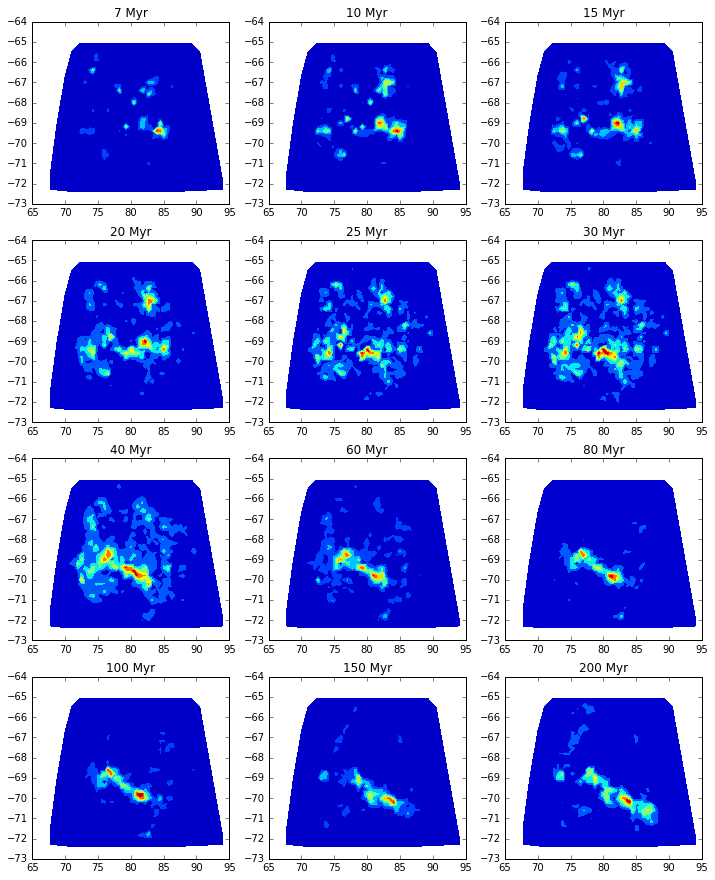

In [11]:

plt.figure(figsize=(12,15))

def get_LMC_plot(age):
    sfr = np.array([])
    for i in np.arange(len(lmc_coor)):
        sfr = np.append(sfr, get_SFH(lmc_coor["ra"][i], lmc_coor["dec"][i], age)[1])

    plt.tricontourf(lmc_coor["ra"], lmc_coor["dec"], sfr)
    plt.title(str(int(age)) + ' Myr')
    plt.ylim(-73, -64)

    return plt
    

    
plt.subplot(4,3,1)
get_LMC_plot(7.0)

plt.subplot(4,3,2)
get_LMC_plot(10.0)

plt.subplot(4,3,3)
get_LMC_plot(15.0)

plt.subplot(4,3,4)
get_LMC_plot(20.0)

plt.subplot(4,3,5)
get_LMC_plot(25.0)

plt.subplot(4,3,6)
get_LMC_plot(30.0)

plt.subplot(4,3,7)
get_LMC_plot(40.0)

plt.subplot(4,3,8)
get_LMC_plot(60.0)

plt.subplot(4,3,9)
get_LMC_plot(80.0)

plt.subplot(4,3,10)
get_LMC_plot(100.0)

plt.subplot(4,3,11)
get_LMC_plot(150.0)

plt.subplot(4,3,12)
get_LMC_plot(200.0)

plt.show()

# Area = 64 deg^2



### Binary evolution functions

In [12]:
def func_MT_forward(M_1_in, M_2_in, A_in, ecc_in):

    M_1_out = M_0 * M_1_in**(1./xi)
    M_2_out = M_1_in + M_2_in - M_1_out
    A_out = A_in * (1.0-ecc_in) * (M_1_in*M_2_in/M_1_out/M_2_out)**2
    
    # Make sure systems don't overfill their Roche lobes
    r_1_max = func_sse_r_MS_max(M_1_out)
    r_1_roche = func_Roche_radius(M_1_in, M_2_in, A_in)
    r_2_max = func_sse_r_MS_max(M_2_out)
    r_2_roche = func_Roche_radius(M_2_in, M_1_in, A_in)
    A_out[np.where(r_1_max > r_1_roche)] = -1.0
    A_out[np.where(r_2_max > r_2_roche)] = -1.0
    
    return M_1_out, M_2_out, A_out

In [13]:
def func_Roche_radius(M1, M2, A):
    q = M1 / M2
    return A * 0.49*q**(2.0/3.0) / (0.6*q**(2.0/3.0) + np.log(1.0 + q**(1.0/3.0)))

In [14]:
def func_SN_forward(M_1_in, M_2, A_in, v_k, theta, phi):
    A_in[np.where(A_in<=0.0)] = 1.0e-50

    v_r = np.sqrt(GGG*(M_1_in + M_2)/A_in)
    v_1 = np.sqrt(2.0*v_k*v_r*np.cos(theta) + v_k*v_k + v_r*v_r)
    
    A_out = 1.0 / (2.0/A_in - v_1*v_1/(GGG*(M_NS+M_2)))
#    v_sys = (M_NS / (M_NS + M_2)) * v_1
    
    # Systemic velocity    
    alpha = (M_1_in / (M_1_in + M_2))    
    beta = (M_NS / (M_NS + M_2))
    
    v_sys = beta*beta*v_k*v_k
    v_sys = v_sys + v_r*v_r*(beta-alpha)*(beta-alpha)
    v_sys = v_sys + 2.0*beta*v_k*v_r*np.cos(theta)*(beta-alpha)
    v_sys = np.sqrt(v_sys)
    
    # Eccentricity
    e_tmp = v_k*v_k*np.cos(theta)*np.cos(theta) 
    e_tmp = e_tmp + v_k*v_k*np.sin(theta)*np.sin(theta)*np.sin(phi)*np.sin(phi) 
    e_tmp = e_tmp + 2.0*v_k*v_r*np.cos(theta)
    e_tmp = e_tmp + v_r*v_r
    e_tmp = 1.0 - (A_in*A_in)/(A_out*GGG*(M_NS+M_2)) * e_tmp
        
    if isinstance(e_tmp, np.ndarray):
        
        ecc = np.sqrt(e_tmp)
        ecc[np.where(e_tmp < 0.0)] = -1.0
        ecc[np.where(e_tmp > 1.0)] = -1.0
        ecc[np.where(M_2 < min_mass)] = -1.0
        ecc[np.where(A_in < 1.0e-10)] = -1.0
#        ecc = np.array([np.sqrt(x) if x > 0.0 or M_2 > min_mass or A_in>1.0e-10 else -1.0 for x in e_tmp])
    else:
        if e_tmp < 0.0 or M_2 < min_mass or A_in < 1.0e-10: return A_out, v_sys, -1.0
        ecc = np.sqrt(e_tmp)
    
    return A_out, v_sys, ecc

In [15]:
def func_get_time(M1, M2, t_obs):

    t_lifetime_1 = func_sse_ms_time(M1)
    he_mass_1 = func_sse_he_mass(M1)
    
    t_lifetime_2 = func_sse_ms_time(M2)
    he_mass_2 = func_sse_he_mass(M2)
    
    # Relative lifetime through star 2 at mass gain
    he_mass = t_lifetime_1/t_lifetime_2 * he_mass_2
    
    # Get new secondary parameters
    mass_new = M2 + M1 - he_mass_1
    t_lifetime_new = func_sse_ms_time(mass_new)
    he_mass_new = func_sse_he_mass(mass_new)

    # New, effective lifetime
    t_eff = he_mass / he_mass_new * t_lifetime_new
    
    # Now, we obtain the "effective observed time"
    return t_eff + t_obs - t_lifetime_1
         

In [16]:
def get_v_wind(mass, radius):
    
    slope = (7.0 - 0.5) / (120.0 - 1.4)
    intercept = 7.0 - 120.0 * slope
    
    beta = slope * mass + intercept
    
    # For systems with radius = 0.0, set wind arbitrarily high
    one_over_radius = 1.0e50 * np.ones(len(radius))
    one_over_radius[np.where(radius>0.0)] = 1.0 / radius[np.where(radius>0.0)]
    
    return np.sqrt(2.0 * beta * GGG * mass * one_over_radius)

In [17]:
def func_Lx_forward(M_1_a, M_2_a, M_2_in, A_in, ecc_in, t_obs):
    
    t_eff_obs = func_get_time(M_1_a, M_2_a, t_obs)
    
    if isinstance(t_eff_obs, np.ndarray):
        M_2_out = np.array([])
        M_dot_wind = np.array([])
        R_out = np.array([])
        for i in np.arange(len(t_eff_obs)):
            if (t_eff_obs[i] < 0.0 or ecc_in[i] < 0.0 or ecc_in[i] >= 1.0): 
                ecc_in[i] = 0.0
                if isinstance(M_2_in, np.ndarray):
                    M_2_out = np.append(M_2_out, M_2_in[i])
                else:
                    M_2_out = np.append(M_2_out, M_2_in)
                M_dot_wind = np.append(M_dot_wind, 0.0)
                R_out = np.append(R_out, 0.0)
            else:
                if isinstance(M_2_in, np.ndarray):
                    if M_2_in[i] > max_mass: 
                        a, b, c = 0.0, 0.0, 0.0
                    else:
                        a, b, c = func_get_sse_star(M_2_in[i], t_eff_obs[i])
                else:
                    if M_2_in > max_mass: 
                        a, b, c = 0.0, 0.0, 0.0
                    else:
                        a, b, c = func_get_sse_star(M_2_in, t_eff_obs[i])

                M_2_out = np.append(M_2_out, a)
                M_dot_wind = np.append(M_dot_wind, b)    
                R_out = np.append(R_out, c)
    else:
        if (t_eff_obs < 0.0 or M_2_in > max_mass or ecc_in < 0.0 or ecc_in > 1.0): 
            M_2_out = M_2_in
            M_dot_wind = 0.0
            R_out = 0.0
            ecc_in = 0.0
        else:
            M_2_out, M_dot_wind, R_out = func_get_sse_star(M_2_in, t_eff_obs)

    # Get wind velocity
    v_wind = get_v_wind(M_2_out, R_out)
    v_wind[np.where(v_wind <= 0.0)] = 1.0e50 # To eliminate "bad" winds
    
    # Get final orbital separation
    A_in[np.where(A_in <= 0.0)] = 1.0e50 # To eliminate "bad" separations
    A_out = (M_NS + M_2_in) / (M_NS + M_2_out) * A_in
    
    # Capture fraction takes into account eccentricity
    f_capture = (GGG*M_NS / (v_wind*v_wind*A_out))**2 / np.sqrt(1.0 - ecc_in**2)
    M_dot_out = f_capture * M_dot_wind
        
    L_bol = GGG * M_NS * M_dot_out / R_NS * km_to_cm * Msun_to_g * Rsun_to_cm / yr_to_sec
    L_x = L_bol
        
    
    return M_2_out, L_x

In [18]:
def full_forward(M1, M2, A, ecc, v_k, theta, phi, t_obs):

    # MT phase
    M_1_b, M_2_b, A_b = func_MT_forward(M1, M2, A, ecc)

    # SN
    A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)
        
    # XRB
    M_2_tmp, L_x_tmp = func_Lx_forward(M1, M2, M_2_b, A_tmp, e_tmp, t_obs)
    
    M_2_out = M_2_tmp[np.where(e_tmp>0.0) or np.where(e_tmp<1.0) or np.where(L_x_tmp>1.0e32) or np.where(A_b>1.0)]
    L_x_out = L_x_tmp[np.where(e_tmp>0.0) or np.where(e_tmp<1.0) or np.where(L_x_tmp>1.0e32) or np.where(A_b>1.0)]
    v_sys_out = v_sys_tmp[np.where(e_tmp>0.0) or np.where(e_tmp<1.0) or np.where(L_x_tmp>1.0e32) or np.where(A_b>1.0)]    
    
    
    indices = np.intersect1d(np.where(L_x_tmp>1.0e32), np.where(e_tmp>0.0))
    indices = np.intersect1d(indices, np.where(e_tmp<1.0))
    indices = np.intersect1d(indices, np.where(A_b>1.0))
    
    
    ran_theta_proj = get_theta(len(indices))
    dist = v_sys_tmp[indices] * (t_obs - func_sse_tmax(M1[indices]))*1.0e6*yr_to_sec * np.sin(ran_theta_proj)
    return L_x_tmp[indices], dist / dist_LMC
    

### Population synthesis functions

In [19]:
# Define random deviate functions

def get_v_k(sigma, N):
    return maxwell.rvs(scale = sigma, size = N)

def get_theta(N):
    return np.arccos(1.0-2.0*uniform.rvs(size = N))

def get_phi(N):
    return 2.0*np.pi*uniform.rvs(size = N)

def get_M1(x1, x2, alpha, N):

    A = (alpha+1.0) / (np.power(x2, alpha+1.0) - np.power(x1, alpha+1.0))
    x = uniform.rvs(size = N)
    
    return np.power(x*(alpha+1.0)/A + np.power(x1, alpha+1.0), 1.0/(alpha+1.0))
    
# Mass ratio - uniform [0.3,1.0]
def get_q(N):
    return 0.7 * uniform.rvs(size = N) + 0.3 
    
def get_A(a1, a2, N):
    
    x1 = np.log10(a1)
    x2 = np.log10(a2)
    
    return np.power(10.0, (x2-x1)*uniform.rvs(size=N) + x1)

def get_ecc(N):
    return np.sqrt(uniform.rvs(size=N))

In [20]:
M1_min = 8.0   # Minimum primary mass
M1_max = 30.0  # Maximum primary mass
alpha = -2.35  # IMF power law index
sigma_Fe = 265.0  # Kick velocity maxwellian dispersion - Fe-core SN
sigma_ECS = 50.0  # Kick velocity maxwellian dispersion - ECS
ECS_Fe_mass = 10.0  # Mass differentiating ECS from Fe-core collapse
A_min = 100.0  # Minimum orbital separation (Rsun)
A_max = 2.0e5  # Maximum orbital separation (Rsun) roughly 10^3 AU

In [21]:
def generate_population(N):
    
    theta = get_theta(N)
    phi = get_phi(N)
    M_1_a = get_M1(M1_min, M1_max, alpha, N)
    M_2_a = get_q(N) * M_1_a
    ecc_a = get_ecc(N)
    
    # Kick velocities depend on the core mass
    sigma = map(lambda m: sigma_ECS if m<ECS_Fe_mass else sigma_Fe, M_1_a)
    v_k = get_v_k(sigma, N)

    # To get Orbital Separation limits, need to take into account star radii
    r_1_MS_max = func_sse_r_MS_max(M_1_a)
    r_1_ZAMS = func_sse_r_ZAMS(M_1_a)
    r_1_roche = func_Roche_radius(M_1_a, M_2_a, 1.0)
    r_2_MS_max = func_sse_r_MS_max(M_2_a)
    r_2_ZAMS = func_sse_r_ZAMS(M_2_a)
    r_2_roche = func_Roche_radius(M_2_a, M_1_a, 1.0)
    # Neither star can fill its Roche lobe at ZAMS
    A_min = np.zeros(N)
    for i in np.arange(N):
        A_min[i] = max(r_1_ZAMS[i]/r_1_roche[i], r_2_ZAMS[i]/r_2_roche[i])
    # Now, adjust A for eccentricity
    A_min = A_min / (1.0 - ecc_a)
    r_1_max = func_sse_rmax(M_1_a)
    # But the primary must fill its Roche lobe at some point
    A_max = r_1_max/r_1_roche
    A_a = np.zeros(N)
    for i in np.arange(N): A_a[i] = get_A(A_min[i], A_max[i], 1)
    
    return M_1_a, M_2_a, A_a, ecc_a, v_k, theta, phi
    

In [22]:
def get_random_positions(N, t_b):

    N_regions = len(SF_history)

    SF_regions = np.zeros((2,N_regions))
    for i in np.arange(N_regions):
        SF_regions[0,i] = i
        SF_regions[1,i] = SF_history[i](np.log10(t_b*1.0e6))
        
    N_stars = np.sum(SF_regions, axis=1)[1]

    # Normalize
    SF_regions[1] = SF_regions[1] / N_stars

    # Sort
    SF_sort = SF_regions[:,SF_regions[1].argsort()]

    # Move from normed PDF to CDF
    SF_sort[1] = np.cumsum(SF_sort[1])

    # TEST #
#    ra_out = lmc_coor["ra"][SF_sort[0][-100:].astype(int)]
#    dec_out = lmc_coor["dec"][SF_sort[0][-100:].astype(int)]
#    return ra_out, dec_out
    # TEST #
        
    # Random numbers
    y = uniform.rvs(size=N)
    
    # Create a 2D grid of CDFs, and random numbers
    SF_out, y_out = np.meshgrid(SF_sort[1], y)

    # Get index of closest region in sorted array
    indices = np.argmin((SF_out - y_out)**2,axis=1)
    
    # Move to indices of stored LMC SFH data array
    indices = SF_sort[0][indices].astype(int)

    # Get random ra's and dec's of each region
    ra_out = lmc_coor["ra"][indices]
    dec_out = lmc_coor["dec"][indices]

    # Width is 12 arcmin or 12/60 degrees for outermost regions
    # Width is 6 arcmin or 6/60 degrees for inner regions
    width = 12.0 / 60.0 * np.ones(len(indices))
    for i in np.arange(len(indices)):
        if str(lmc_coor["region"][indices[i]]).find("_") != -1: 
            width[i] = 6.0 / 60.0

    tmp_delta_ra = width * (2.0 * uniform.rvs(size=len(indices)) - 1.0) / np.cos(dec_to_rad(dec_out)) * 2.0
    tmp_delta_dec = width * (2.0 * uniform.rvs(size=len(indices)) - 1.0)

    ra_out = ra_out + tmp_delta_ra
    dec_out = dec_out + tmp_delta_dec

    return ra_out, dec_out, N_stars

In [23]:
def create_HMXBs(t_b, N_sys=1000):
    M1_i, M2_i, A_i, ecc_i, v_k, theta, phi = generate_population(N_sys)

    L_x, theta_proj = full_forward(M1_i, M2_i, A_i, ecc_i, v_k, theta, phi, t_b)
    N_survive = len(L_x)
    pos_ang_expand = 2.0*np.pi * uniform.rvs(size = 10*N_survive)

    L_x_expand = np.zeros(10*N_survive)
    theta_proj_expand = np.zeros(10*N_survive)
    for i in np.arange(10): 
        L_x_expand[i::10] = L_x
        theta_proj_expand[i::10] = theta_proj

    

    ra_birth, dec_birth, N_stars_time = get_random_positions(10*N_survive, t_b)

    ra_new, dec_new = get_new_ra_dec(ra_birth, dec_birth, theta_proj_expand, pos_ang_expand)

    names = ["ra", "dec", "ra_b", "dec_b", "L_x", "age", "norm"]
    HMXB = np.recarray(10*N_survive, names=names, formats=['float64,float64,float64,float64,float64,float64,float64'])
    HMXB["ra"] = ra_new
    HMXB["dec"] = dec_new
    HMXB["ra_b"] = ra_birth
    HMXB["dec_b"] = dec_birth
    HMXB["L_x"] = L_x_expand
    HMXB["age"] = t_b
    HMXB["norm"] = N_stars_time

    return HMXB
    
#get_LMC_plot(30.0)
#plt.scatter(ra_new, dec_new, marker='.', color='k')
#plt.show()

In [24]:
names = ["ra", "dec", "ra_b", "dec_b", "L_x", "age", "norm"]
HMXB = np.recarray(0, names=names, formats=['float64,float64,float64,float64,float64,float64,float64'])



for t_b in np.linspace(1.0, 75.0, 60):
    HMXB_t = create_HMXBs(t_b, N_sys=10000)
    HMXB = np.concatenate((HMXB, HMXB_t))

print HMXB.shape

(210950,)


/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide


In [25]:
from astropy import units as u
import astropy.coordinates as coord
from astropy.wcs import WCS

Dor_30 = coord.SkyCoord('05h38m38s', '-69d05.7m')
print Dor_30

<SkyCoord (ICRS): (ra, dec) in deg
    (84.65833333, -69.095)>


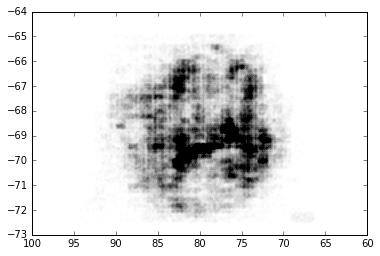

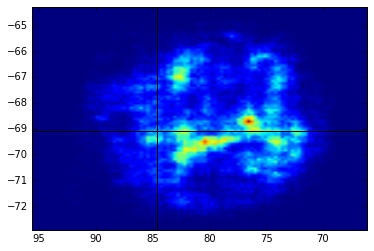

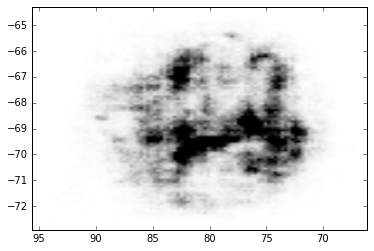

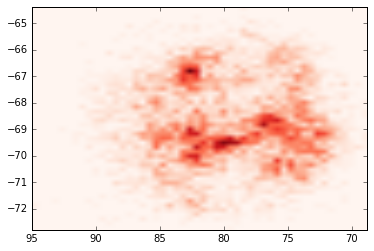

In [34]:
#t_b = 35.0
#get_LMC_plot(t_b)
#plt.scatter(HMXB["ra"][np.where(HMXB["age"]==t_b)], HMXB["dec"][np.where(HMXB["age"]==t_b)], color='k', marker='.')
#plt.scatter(HMXB["ra"], HMXB["dec"], color='k', marker='.', alpha=0.05)
#plt.show()

sxgml_coor = coord.SkyCoord(HMXB["ra"], HMXB["dec"], unit='deg')
#print sxgml_coor.ra.hms, sxgml_coor.dec.dms


#plt.scatter(sxgml_coor.ra.hms, sxgml_coor.dec.dms, color='k', marker='.', alpha=0.005)
plt.scatter(HMXB["ra_b"], HMXB["dec_b"], color='k', marker='.', alpha=0.005)
#plt.xlim(100, 60)
plt.xlim(reversed(plt.xlim()))
plt.show()


# All HMXBs
HMXB_hist, xedges, yedges = np.histogram2d(HMXB["ra"], HMXB["dec"], bins=100, weights=HMXB["norm"])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig = plt.figure()
HMXB_plot = fig.add_subplot(111)
HMXB_plot.imshow(HMXB_hist.T, extent=extent, origin='lower', aspect='auto')
plt.axhline(Dor_30.dec.degree, color='k')
plt.axvline(Dor_30.ra.degree, color='k')
plt.xlim(reversed(plt.xlim()))
#plt.savefig('../figures/forward_LMC_HMXBs_color.pdf')
plt.show()

# All HMXBs
HMXB_hist, xedges, yedges = np.histogram2d(HMXB["ra"], HMXB["dec"], bins=100, weights=HMXB["norm"])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig = plt.figure()
HMXB_plot = fig.add_subplot(111)
imgplot = HMXB_plot.imshow(HMXB_hist.T, extent=extent, origin='lower', aspect='auto', cmap=cm.Greys, clim=[0.0,3.0e7])
#plt.savefig('../figures/forward_LMC_HMXBs_bw.pdf')
plt.xlim(reversed(plt.xlim()))
plt.show()



# HMXBs with L_x > 10^39
HMXB_hist, xedges, yedges = np.histogram2d(HMXB["ra"][np.where(HMXB["L_x"]>1.0e39)], HMXB["dec"][np.where(HMXB["L_x"]>1.0e39)], bins=50, weights=HMXB["norm"][np.where(HMXB["L_x"]>1.0e39)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig = plt.figure()
HMXB_plot = fig.add_subplot(111)
HMXB_plot.imshow(HMXB_hist.T, extent=extent, origin='lower', aspect='auto', cmap=cm.Reds)
plt.xlim(reversed(plt.xlim()))
plt.show()







[ 6.74158809  6.48451237  6.90982116 ...,  1.3243291   1.8518171
  4.25026941]


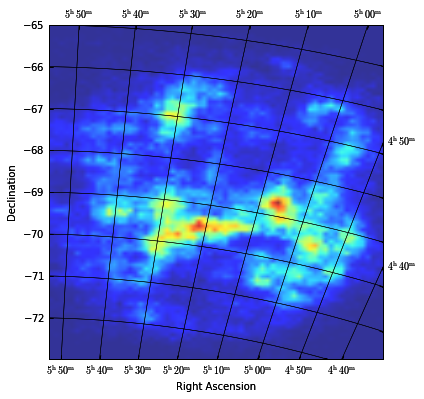

In [36]:
import  mpl_toolkits.axisartist.angle_helper as angle_helper
from matplotlib.projections import PolarAxes
from matplotlib.transforms import Affine2D
from mpl_toolkits.axisartist import SubplotHost
from mpl_toolkits.axisartist import GridHelperCurveLinear



def curvelinear_test2(fig, rect=111):
    """
    polar projection, but in a rectangular box.
    """

    # see demo_curvelinear_grid.py for details
    tr = Affine2D().translate(0,90) + Affine2D().scale(np.pi/180., 1.) + PolarAxes.PolarTransform()

    extreme_finder = angle_helper.ExtremeFinderCycle(10, 60,
                                                     lon_cycle = 360,
                                                     lat_cycle = None,
                                                     lon_minmax = None,
                                                     lat_minmax = (-90, np.inf),
                                                     )

    grid_locator1 = angle_helper.LocatorHMS(12) #changes theta gridline count
    tick_formatter1 = angle_helper.FormatterHMS()

    grid_helper = GridHelperCurveLinear(tr,
                                        extreme_finder=extreme_finder,
                                        grid_locator1=grid_locator1,
                                        tick_formatter1=tick_formatter1
                                        )


    ax1 = SubplotHost(fig, rect, grid_helper=grid_helper)

    # make ticklabels of right and top axis visible.
    ax1.axis["right"].major_ticklabels.set_visible(True)
    ax1.axis["top"].major_ticklabels.set_visible(True)
    ax1.axis["bottom"].major_ticklabels.set_visible(True) #Turn off? 
    # let right and bottom axis show ticklabels for 1st coordinate (angle)
    ax1.axis["right"].get_helper().nth_coord_ticks=0
    ax1.axis["bottom"].get_helper().nth_coord_ticks=0



    fig.add_subplot(ax1)

    grid_helper = ax1.get_grid_helper()

    # You may or may not need these - they set the view window explicitly rather than using the
    # default as determined by matplotlib with extreme finder.
    ax1.set_aspect(1.)
    ax1.set_xlim(0.5, 7) # moves the origin left-right in ax1
    ax1.set_ylim(17, 25) # moves the origin up-down

    ax1.set_ylabel('Declination')
    ax1.set_xlabel('Right Ascension')
    ax1.grid(True, linestyle='-')
    #ax1.grid(linestyle='--', which='x') # either keyword applies to both
    #ax1.grid(linestyle=':', which='y')  # sets of gridlines

    return ax1,tr


fig = plt.figure(1, figsize=(6, 6))
fig.clf()

ax1, tr = curvelinear_test2(fig,111) # tr.transform_point((x, 0)) is always (0,0)
                            # => (theta, r) in but (r, theta) out...             

# Read RA, DEC data from file.
ra = HMXB["ra"]
dec = HMXB["dec"]
out_test = tr.transform(zip(ra, dec))


# Use this block to generate colored points with a colorbar.
#cm = plt.cm.get_cmap('RdYlBu_r')
#z = np.random.random((len(ra), 1))  # RGB values



HMXB_hist, xedges, yedges = np.histogram2d(out_test[:,0], out_test[:,1], bins=100, weights=HMXB["norm"])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

ax1.imshow(HMXB_hist.T, extent=extent, origin='lower', aspect='auto', alpha=0.8)
#ax1.scatter(out_test[:,0],out_test[:,1], marker='.', alpha=0.01, color='k')



#plt.savefig('../figures/forward_LMC_HMXBs_color.pdf')
plt.show()


#ax1.imshow(HMXB_hist.T, extent=extent, origin='lower', aspect='auto', cmap=cm.Greys, clim=[0.0,7.0e7])
#plt.savefig('../figures/forward_LMC_HMXBs_bw.pdf')


